In [13]:
import torch
from torch.utils.data import Dataset
import mne
mne.set_log_level(verbose='CRITICAL')
import numpy as np
from typing import Callable
import os
from alltools.storage_management import check_path
from alltools.machine_learning import one_hot_encoder
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict
import torch.nn as nn
from tqdm import tqdm
from time import sleep
from typing import Generator, TextIO
import contextlib
import sys
from tqdm import tqdm
from functools import partial
import torchmetrics
import matplotlib.pyplot as plt
import random
from collections.abc import Sequence
from copy import deepcopy


def read_epochs_dataset(path: str | os.PathLike):
    """Reads epochs dataset in '.pt' format"""
    return torch.load(path)


def compute_train_val_indices(n_samples: int, batch_size: int, val_batch_size: int, shuffle: bool = True) -> tuple[list[int], list[int]]:
    """
    Computes the indices for the training and validation sets.

    Args:
        n_samples (int): the total number of samples in the dataset
        batch_size (int): the number of samples in a batch for the training set
        val_batch_size (int): the number of samples in a batch for the validation set
        shuffle (bool): whether to shuffle indices

    Returns:
        Tuple[List[int], List[int]] : a tuple containing two lists of integers representing the indices of the samples in the training and validation sets respectively.
    """
    val_ratio = val_batch_size/(batch_size + val_batch_size)
    all_indices = list(range(n_samples))

    if shuffle:
        random.shuffle(all_indices)

    n_indices = len(all_indices)
    start = 0
    dist = batch_size + val_batch_size
    end = dist
    train_indices, val_indices = list(), list()

    while True:
        slice_ = slice(start, end)
        group = all_indices[slice_]
        actual_batch_size = int(len(group)*val_ratio)
        train_indices += group[actual_batch_size:]
        val_indices += group[:actual_batch_size]

        if end is None:
            break

        start = end
        estimated_end = end + dist
        end = estimated_end if estimated_end <= n_indices else None

    return train_indices, val_indices


def make_train_and_val_loaders(
    dataset: torch.utils.data.Dataset,
    batch_size: int,
    val_batch_size: int,
    shuffle: bool=True
) -> tuple[DataLoader, DataLoader]:
    """
    Creates PyTorch DataLoaders for the training and validation sets.

    Args:
        dataset (torch.utils.data.Dataset): the dataset to create the DataLoaders from
        batch_size (int): the number of samples in a batch for the training set
        val_batch_size (int): the number of samples in a batch for the validation set
        shuffle (bool): whether to shuffle the dataset before splitting into train and val sets
    Returns:
        Tuple[DataLoader, DataLoader]: a tuple of PyTorch DataLoader objects for the training and validation sets respectively.
    """
    train_indices, val_indices = compute_train_val_indices(len(dataset), batch_size, val_batch_size, shuffle=shuffle)
    return DataLoader(dataset, batch_size, sampler=train_indices), DataLoader(dataset, val_batch_size, sampler=val_indices)



class EpochsDataset(Dataset):
    """
    A PyTorch dataset class for working with data from MNE Epochs.
    """
    def __init__(
        self,
        epochs: str | os.PathLike | tuple[np.ndarray, np.ndarray] | mne.Epochs,
        transform: Callable[[torch.Tensor], torch.Tensor] = None,target_transform: Callable  = None,
        savepath: str | os.PathLike = './data'
    ):
        """
        Initialize the EpochsDataset object.

        Args:
            epochs (Union[str, os.PathLike, Tuple[np.ndarray, np.ndarray], mne.Epochs]): path to an MNE Epochs file, an MNE Epochs object, a tuple of numpy arrays containing the data and targets, or an MNE EpochsArray object.
            transform (Optional[Callable[[torch.Tensor], torch.Tensor]]): a function to be applied to the data samples.
            target_transform (Optional[Callable]): a function to be applied to the targets.
            savepath (Union[str, os.PathLike]): the path to the directory where the data samples and targets will be saved.
        Raises:
            ValueError: if the epochs file is not in a supported format (path to mne.Epochs, mne.Epochs or sample-target couples of torch.Tensor)

        """
        if isinstance(epochs, (str, os.PathLike)):
            epochs = mne.read_epochs(epochs)

        if isinstance(epochs, (mne.Epochs, mne.epochs.EpochsArray)):
            data = epochs.get_data()
            X = [torch.Tensor(sample) for sample in data]
            Y = one_hot_encoder(epochs.events[:, 2])
            Y = [torch.Tensor(event) for event in Y]
        elif isinstance(epochs, tuple):
            X = [torch.Tensor(sample) for sample in epochs[0]]
            Y = [torch.Tensor(target) for target in epochs[1]]
        else:
            raise ValueError(f'Unsupported type for data samples: {type(epochs)}')

        self.n_samples = len(X)
        self.savepath = savepath
        self.transform = transform
        self.target_transform = target_transform

        check_path(savepath)

        for i, (sample, target) in enumerate(zip(X, Y)):
            torch.save(sample, os.path.join(self.savepath, f'sample_{i}.pt'))
            torch.save(target, os.path.join(self.savepath, f'target_{i}.pt'))

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return self.n_samples

    def __getitem__(self, idx):
        """
        Retrieves the sample and target at the given index.

        Args:
            idx (int): the index of the sample and target to be retrieved.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The sample and target at the given index.
        """
        sample_path = os.path.join(self.savepath, f'sample_{idx}.pt')
        target_path = os.path.join(self.savepath, f'target_{idx}.pt')

        X = torch.load(sample_path)
        Y = torch.load(target_path)

        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            Y = self.target_transform(Y)

        return X, Y

    def save(self, path: str | os.PathLike):
        """
        Saves the EpochsDataset object to a specified path.

        Args:
            path (Union[str, os.PathLike]): the path where the object should be saved.
        """
        torch.save(self, path)


class DummyFile(object):
    """
    A class that wraps a file object, replacing the 'write' method to avoid print() second call (useless \\n).
    """
    file: TextIO
    def __init__(self, file: TextIO):
        """
        Initialize the DummyFile object.

        Args:
            - file (TextIO) : The file object to be wrapped.
        """
        self.file = file

    def write(self, x: str):
        """
        Writes the given string to the wrapped file object, avoiding print() second call (useless \\n).

        Args:
            - x (str) : the string to be written.
        """
        # Avoid print() second call (useless \n)
        if len(x.rstrip()) > 0:
            tqdm.write(x, file=self.file)

@contextlib.contextmanager
def nostdout() -> Generator:
    """
    A context manager that temporarily redirects the stdout to a DummyFile object.
    """
    save_stdout = sys.stdout
    sys.stdout = DummyFile(sys.stdout)
    yield
    sys.stdout = save_stdout


class Callback:
    """
    A base class for callbacks. The methods of this class are called by a `Trainer` during the training process.
    """
    def __init__(
        self
    ):
        """
        Initializes the callback.
        """
        self.trainer = None

    def set_trainer(self, trainer: 'Trainer'):
        """
        Sets the trainer object that will be calling the callback's methods.

        Args:
            trainer (Trainer): The trainer object.
        """
        self.trainer = trainer

    def on_batch_begin(
        self,
        X: torch.Tensor,
        Y: torch.Tensor
    ):
        """
        Called at the beginning of a batch of training/evaluating data.

        Args:
            X (torch.Tensor): Input data of the batch.
            Y (torch.Tensor): Target data of the batch.
        """
        ...

    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        """
        Called at the end of a batch of training/evaluating data.

        Args:
            Y (torch.Tensor): Target data of the batch.
            Y_pred (torch.Tensor): Predicted data of the batch.
            metrics (dict): A dictionary containing the batch's metrics.
        """
        ...

    def on_epoch_begin(
        self,
        epoch_number: int
    ):
        """
        Called at the beginning of an epoch of training.

        Args:
            epoch_number (int): The number of the current epoch.
        """
        ...

    def on_epoch_end(
        self,
        epoch_number: int,
        metrics: dict
    ):
        """
        Called at the end of an epoch of training.

        Args:
            epoch_number (int): The number of the current epoch.
            metrics (dict): A dictionary containing the epoch's metrics.
        """
        ...

    def on_train_batch_begin(
        self,
        X: torch.Tensor,
        Y: torch.Tensor
    ):
        """
        Called at the beginning of a batch of training data, during the training phase.

        Args:
            X (torch.Tensor): Input data of the batch.
            Y (torch.Tensor): Target data of the batch.
        """
        ...

    def on_train_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict()
    ):
        """
        Called at the end of a batch of training data, during the training phase.

        Args:
            Y (torch.Tensor): Target data of the batch.
            Y_pred (torch.Tensor): Predicted data of the batch.
            metrics (dict): A dictionary containing the batch's metrics.
        """
        ...

    def on_evaluate_begin(
        self,
    ):
        """
        Called at the beginning of the evaluation phase.
        """
        ...

    def on_evaluate_end(
        self,
        metrics: dict
    ):
        """
        Called at the end of the evaluation phase.

        Args:
            metrics (dict): A dictionary containing the evaluation metrics.
        """
        ...

    def on_eval_batch_begin(
        self,
        X: torch.Tensor,
        Y: torch.Tensor
    ):
        """
        This method is called at the beginning of each evaluation batch.

        Args:
            X (torch.Tensor): The input data of the current batch.
            Y (torch.Tensor): The target data of the current batch.
        """
        ...

    def on_eval_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        """
        This method is called at the end of each evaluation batch.

        Args:
            Y (torch.Tensor): The true labels of the batch.
            Y_pred (torch.Tensor): The predicted labels of the batch.
            metrics (dict): A dictionary containing the current evaluation metrics of the model.
        """
        ...

    def on_loss_computed(
        self,
        X: torch.Tensor,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        loss: torch.Tensor
    ):
        """Called after the loss for a batch of data has been computed.

        This function is called after the loss for a batch of data has been computed, but before the gradients are computed and applied.
        This is useful for any computations that need to be done before the gradients are computed and applied.

        Args:
            X (torch.Tensor): A batch of input data.
            Y (torch.Tensor): A batch of target data.
            Y_pred (torch.Tensor): A batch of predicted data.
            loss (torch.Tensor): The computed loss for this batch of data.
        """
        ...

class Trainer:
    """
    A class for training deep learning models with PyTorch.
    """

    def __init__(
        self, model: nn.Module, optimizer: torch.optim.Optimizer,
        criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        device: str, metric_functions: list[tuple[str, Callable]] = None,
        epoch_number: int = 0,
        lr_scheduler: Optional[Any] = None,
        callbacks: Callback | list[Callback] = None
    ):
        """
        Initialize the trainer.

        Args:
            model (nn.Module): the PyTorch model to be trained.
            optimizer (torch.optim.Optimizer): the optimizer to be used for training.
            criterion (Callable[[torch.Tensor, torch.Tensor], torch.Tensor]): the loss function to be used for training.
            device (str): the device on which the training should be done (e.g. 'cpu' or 'cuda').
            metric_functions (List[Tuple[str, Callable]]): list of tuples containing the name of the metric and a callable that calculates that metric.
            epoch_number (int): the number of epochs for which the model should be trained.
            lr_scheduler (Optional[Any]): the learning rate scheduler to be used.
        """
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.metric_functions = metric_functions if metric_functions else list()
        self.epoch_number = epoch_number
        self.__interrupt = False

        if callbacks:
            if isinstance(callbacks, Callback):
                callbacks.set_trainer(self)
                self.callbacks = [callbacks]
            elif isinstance(callbacks, Sequence):
                for callback in callbacks:
                    callback.set_trainer(self)

                self.callbacks = callbacks
            else:
                raise ValueError(f'Callbacks must be either Sequence or Callback instance, instead {type(callbacks)} is given')
        else:
            self.callbacks = callbacks

    def interrupt(self, interrupt: bool = True):
        """Immediately stop training/evaluation"""
        self.__interrupt = interrupt

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[dict[str, float]]:
        """
        Evaluates the model on a single batch of validation data.

        Args:
            val_iterator (Iterator): an iterator over the validation data.
            eval_on_n_batches (int): the number of batches to evaluate the model on.

        Returns:
            Optional[Dict[str, float]]: a dictionary containing the evaluation metrics.
        """
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):

            try:
                xs, ys_true = next(val_iterator)

                xs = xs.to(self.device)
                ys_true = ys_true.to(self.device)

                if self.callbacks:
                    for callback in self.callbacks:
                        callback.on_batch_begin(xs, ys_true)
                        callback.on_eval_batch_begin(xs, ys_true)
                if self.__interrupt:
                    break
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            if self.callbacks:
                for callback in self.callbacks:
                    new_loss = callback.on_loss_computed(xs, ys_true, ys_pred, loss)

                    if new_loss is not None:
                        loss = new_loss

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_batch_end(targets, predictions, metrics)
                callback.on_eval_batch_end(targets, predictions, metrics)

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader: DataLoader, eval_on_n_batches: int = 1) -> dict[str, float]:
        """
        Evaluates the model on the validation data.

        Args:
            val_loader (DataLoader): a PyTorch DataLoader containing the validation data.
            eval_on_n_batches (int): the number of batches through which to evaluate the model.

        Returns:
            Dict[str, float]: a dictionary containing the evaluation metrics.
        """
        self.interrupt(False)
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_evaluate_begin()

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None or self.__interrupt:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_evaluate_end(metrics)

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Trains the model on a single batch of training data.

        Args:
            train_iterator (Iterator): an iterator over the training data.
            update_every_n_batches (int): the number of batches to train the model on before performing weight update.

        Returns:
            Optional[Dict[str, float]]: a dictionary containing the training metrics.
        """
        self.optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):

            try:
                xs, ys_true = next(train_iterator)

                xs = xs.to(self.device)
                ys_true = ys_true.to(self.device)

                if self.callbacks:
                    for callback in self.callbacks:
                        callback.on_batch_begin(xs, ys_true)
                        callback.on_train_batch_begin(xs, ys_true)

                if self.__interrupt:
                    raise StopIteration
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            if self.callbacks:
                for callback in self.callbacks:
                    new_loss = callback.on_loss_computed(xs, ys_true, ys_pred, loss)

                    if new_loss is not None:
                        loss = new_loss

            (loss / update_every_n_batches).backward()
            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        if self.callbacks:
            for callback in self.callbacks:
                callback.on_batch_end(targets, predictions, metrics)
                callback.on_train_batch_end(targets, predictions, metrics)

        return metrics

    def fit_epoch(self, train_loader: DataLoader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Trains the model on a single epoch of training data.

        Args:
            train_loader (DataLoader): a PyTorch DataLoader containing the training data.
            update_every_n_batches (int): the number of batches to train the model on before performing weight update.
            log_every_n_batches (int): the number of batches to log training metrics.

        Returns:
            Dict[str, float]: a dictionary containing the average training metrics for the epoch.
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None or self.__interrupt:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader: DataLoader, num_epochs: int,
            val_loader: DataLoader = None, update_every_n_batches: int = 1,
            eval_on_n_batches: int = 1, eval_every_n_epochs: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Trains the model for a specified number of epochs.

        Args:
            train_loader (DataLoader): a PyTorch DataLoader containing the training data.
            val_loader (DataLoader): a PyTorch DataLoader containing the validation data.
            num_epochs (int): the number of training epochs.
            update_every_n_batches (int) : the number of batches to train the model on before performing weight update.
            log_every_n_batches (int): the number of batches to log training metrics.
            eval_every_n_epochs (int): the number of training epochs between evaluations.
            eval_on_n_batches (int): the number of batches to evaluate the model on.

        Returns:
            Dict[str, List[Dict[str, float]]]: a dictionary containing the training and validation metrics for each epoch.
        """
        self.interrupt(False)

        summary = defaultdict(list)

        def save_metrics(metrics: dict[str, float], postfix: str = '') -> None:
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)
        import traceback
        try:
            for i in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs, file=sys.stdout):
                with nostdout():

                    self.epoch_number += 1

                    if self.__interrupt:
                        print(f'The training loop was completed at epoch {self.epoch_number} due to an interruption')
                        self.interrupt(False)
                        break

                    if self.callbacks:
                        for callback in self.callbacks:
                            callback.on_epoch_begin(i)

                    train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

                    train_metrics = {f'{key}_train': value for key, value in train_metrics.items()}
                    val_metrics = False

                    with torch.no_grad():
                        save_metrics(train_metrics)

                        if val_loader is not None and not i%eval_every_n_epochs:
                            val_metrics = self.evaluate(val_loader, eval_on_n_batches)
                            val_metrics = {f'{key}_val': value for key, value in val_metrics.items()}
                            save_metrics(val_metrics)

                    if self.callbacks:
                        for callback in self.callbacks:
                            all_metrics = train_metrics | val_metrics if val_metrics else train_metrics
                            callback.on_epoch_end(i, all_metrics)

                    if self.lr_scheduler is not None:
                        self.lr_scheduler.step()

            summary = {metric: np.array(summary[metric]) for metric in summary}

            return summary
        except Exception as e:
            print(e)
            traceback.print_exc()
            self.interrupt()


class TinyNet(torch.nn.Module):

    def __init__(self, n_channels, n_latent, n_times, pool_factor, n_outputs):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=False)
        self.unmixing_layer_batchnorm = nn.BatchNorm1d(n_latent, affine=False)
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.features_batchnorm = nn.BatchNorm1d(final_out_features, affine=False)
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x):
        x = self.unmixing_layer(x)
        x = self.unmixing_layer_batchnorm(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        x = self.features_batchnorm(x)
        return self.fc_layer(x)


class SimpleNet(torch.nn.Module):

    def __init__(self, n_channels, n_latent, n_times, filter_size, pool_factor, n_outputs):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1)
        self.unmixing_layer_batchnorm = nn.BatchNorm1d(n_latent, affine=False)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=False, groups=n_latent, padding='same')
        self.temp_conv_activation = nn.LeakyReLU(-1)
        self.env_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.features_batchnorm = nn.BatchNorm1d(final_out_features, affine=False)
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x):
        x = self.unmixing_layer(x)
        x = self.unmixing_layer_batchnorm(x)
        x = self.temp_conv(x)
        x = self.temp_conv_activation(x)
        x = self.env_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        x = self.features_batchnorm(x)
        return self.fc_layer(x)


class LFCNN(torch.nn.Module):

    def __init__(self, n_channels, n_latent, n_times, filter_size, pool_factor, n_outputs):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1)
        self.unmixing_layer_batchnorm = nn.BatchNorm1d(n_latent, affine=False)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=False, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.features_batchnorm = nn.BatchNorm1d(final_out_features, affine=False)
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x):
        x = self.unmixing_layer(x)
        x = self.unmixing_layer_batchnorm(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        x = self.features_batchnorm(x)
        return self.fc_layer(x)


def transform(x):
    return (x - x.mean())/x.std()


class MeasureCallback(Callback):
    """
    A callback that allows to add new measure to the history.
    """
    def __init__(self, criterion: Callable[[torch.Tensor, torch.Tensor], float], criterion_name: str):
        """
        Initialize the MeasureCallback class.

        Args:
            criterion (Callable): The criterion function to compute loss between predicted and actual value.
            criterion_name (str): The name of the criterion function.
        """
        super().__init__()
        self.criterion = criterion
        self.criterion_name = criterion_name

    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        """
        Add the loss value to the metrics dictionary after each batch end.

        Args:
            Y (torch.Tensor): The actual value of the target.
            Y_pred (torch.Tensor): The predicted value of the target.
            metrics (dict): A dictionary containing the metrics of the training and evaluation process.
        """
        metrics[self.criterion_name] = self.criterion(Y, Y_pred).item()


class PrintingCallback(Callback):
    """
    A callback that prints the values of metrics after each epoch.
    """
    def __init__(self, sep = '   |    ', format_fn: Callable[[int, dict[str, float]], str] = None):
        """
        Initializes the PrintingCallback.

        Parameters:
            sep (str): separator used to separate the metric names from the metric values in the printout.
            format_fn (Callable[[int, dict[str, float]], str]): a function that takes in the current epoch number
                and a dictionary of metrics and returns a string that will be printed out.
                If not provided, a default function will be used.
        """
        super().__init__()
        self.sep = sep
        self.format_fn = format_fn

    @staticmethod
    def default_format_fn(epoch_num, metrics: dict[str, float], sep: str = ', ') -> str:
        """
        A default function that can be used for formatting the printout if no other function is provided.

        Parameters:
            epoch_num (int): the current epoch number.
            metrics (dict[str, float]): a dictionary of metrics and their values.
            sep (str): separator used to separate the metric-value pairs from each other in the printout.

        Returns:
            str: a formatted string containing the current epoch number and the values of all metrics.
        """
        return f'Epoch {epoch_num}'.ljust(10, ' ') + sep.join(list(map(
            lambda x: f'{x[0]}: {x[1] : .4f}',
            metrics.items()
        )))

    def on_epoch_end(self, epoch_num, metrics):
        """
        This method is called at the end of each epoch.
        It prints the metrics of the epoch, if the format_fn attribute is present, it will use it to format the output,
        otherwise it will use the default_format_fn method.
        Args:
            epoch_num(int): the number of the epoch.
            metrics(dict): the metrics collected during the epoch.
        """
        if self.format_fn:
            print(self.format_fn(epoch_num, metrics, self.sep))
        else:
            print(self.default_format_fn(epoch_num, metrics, self.sep))


class EarlyStopping(Callback):
    """
    A callback that performing early stopping.
    """
    def __init__(self, patience=5, monitor='loss_train', min_delta=0, restore_best_weights=True):
        """
        Initializes the callback.

        Args:
            patience (int): Number of consecutive epochs with no improvement after which training will be stopped.
            monitor (str): The metric to monitor. If it stops improving, training will be stopped.
            min_delta (float): Minimum change in the monitored metric to qualify as an improvement.
            restore_best_weights (bool): Whether to restore the model's best weights when training is stopped.
        """
        super().__init__()
        self.patience = patience
        self.monitor = monitor
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.min_criterion_value = np.inf
        self.best_weights = None

    def set_trainer(self, trainer: 'Trainer'):
        """
        Binds the trainer to the callback.

        Args:
            trainer (Trainer): The trainer object to bind to the callback.
        """
        super().set_trainer(trainer)
        self.model = self.trainer.model

    def on_epoch_end(self, epoch_num, metrics):
        """
        Called at the end of each epoch during training.

        Parameters:
        -----------
        epoch_num : int
            The current epoch number.
        metrics : dict
            Dictionary of metric values computed during the epoch.
        """
        criterion_value = metrics[self.monitor]
        if criterion_value < self.min_criterion_value:
            self.min_criterion_value = criterion_value
            self.counter = 0
            self.best_weights = deepcopy(self.model.state_dict())

        elif criterion_value > (self.min_criterion_value + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    self.restore()

                self.trainer.interrupt()

    def restore(self):
        """
        restore best weights
        """
        self.model.load_state_dict(self.best_weights)


def plot_metrics(metrics):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [14]:
class L1Reg(Callback):
    """
    A callback that performing L1 regularization.
    """
    def __init__(self, layer_names = str | list[str], lambdas: float | list[float] =  None):
        """
        Initializes L1Reg callback

        Args:
            layer_names (Union[str, List[str]]): The name of the layer(s) that need to be regularized. To see possible layer names, check model.state_dict() keys.
            lambdas (Union[float, List[float]], optional): The lambda value(s) for the regularization. Defaults to None.
                If not provided, the default value will be used for all layers.
                If a single value is provided, it will be used for all layers.
                If a list of values is provided, it must have the same length as the layer_names list.
        Raises:
            ValueError: If the length of `layer_names` and `lambdas` is not the same.
        """
        super().__init__()
        self.layer_names = layer_names if isinstance(layer_names, list) else [layer_names]

        if lambdas is None:
            lambdas = [0.01 for _ in range(len(self.layer_names))]
        elif isinstance(lambdas, float):
            lambdas = [lambdas for _ in range(len(self.layer_names))]

        if len(lambdas) != len(self.layer_names):
            raise ValueError(f'Layers to regularize are inconsistent with amount of given lambdas ({len(self.layer_names)} ~ {len(lambdas)})')

        self.lambdas = lambdas

    def set_trainer(self, trainer: 'Trainer'):
        """
        Binds the trainer to the callback

        Args:
            trainer (Trainer): The trainer object
        """
        super().set_trainer(trainer)
        self.model = self.trainer.model

    def on_loss_computed(self, X, Y, Y_pred, loss):
        """
        Computes the loss value with L1 regularization

        Args:
            X (torch.Tensor): The input data
            Y (torch.Tensor): The target data
            Y_pred (torch.Tensor): The model's prediction
            loss (float): The current loss value

        Returns:
            float: The new loss value with L1 regularization added
        """
        state_dict = self.model.state_dict()

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            loss += lambda_*torch.norm(state_dict[layer_name], 1)

        return loss


class L2Reg(L1Reg):
    """
    A callback that performing L2 regularization.
    """
    def on_loss_computed(self, X, Y, Y_pred, loss):
        """
        Computes the loss value with L2 regularization.
        Args:
            X (torch.Tensor): The input data
            Y (torch.Tensor): The target data
            Y_pred (torch.Tensor): The model's prediction
            loss (float): The current loss value
        Returns:
            float: The new loss value with L2 regularization added
        """
        state_dict = self.model.state_dict()

        for layer_name, lambda_ in zip(self.layer_names, self.lambdas):
            loss += lambda_*torch.norm(state_dict[layer_name], 2)

        return loss


In [82]:
model.state_dict().keys()

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'unmixing_layer_batchnorm.running_mean', 'unmixing_layer_batchnorm.running_var', 'unmixing_layer_batchnorm.num_batches_tracked', 'features_batchnorm.running_mean', 'features_batchnorm.running_var', 'features_batchnorm.num_batches_tracked', 'fc_layer.weight', 'fc_layer.bias'])

Epoch 0   loss_train:  2.1570   |    acc_train:  0.4929   |    loss_val:  2.0310   |    acc_val:  0.4847
Epoch 1   loss_train:  1.9890   |    acc_train:  0.5157   |    loss_val:  1.9642   |    acc_val:  0.5055
Epoch 2   loss_train:  1.8414   |    acc_train:  0.5462   |    loss_val:  1.8859   |    acc_val:  0.5253
Epoch 3   loss_train:  1.7048   |    acc_train:  0.5725   |    loss_val:  1.8012   |    acc_val:  0.5514
Epoch 4   loss_train:  1.5796   |    acc_train:  0.5950   |    loss_val:  1.7163   |    acc_val:  0.5726
Epoch 5   loss_train:  1.4659   |    acc_train:  0.6153   |    loss_val:  1.6359   |    acc_val:  0.5836
Epoch 6   loss_train:  1.3628   |    acc_train:  0.6274   |    loss_val:  1.5618   |    acc_val:  0.5924
Epoch 7   loss_train:  1.2690   |    acc_train:  0.6344   |    loss_val:  1.4939   |    acc_val:  0.6055
Epoch 8   loss_train:  1.1829   |    acc_train:  0.6415   |    loss_val:  1.4313   |    acc_val:  0.6150
Epoch 9   loss_train:  1.1034   |    acc_train:  0.6480

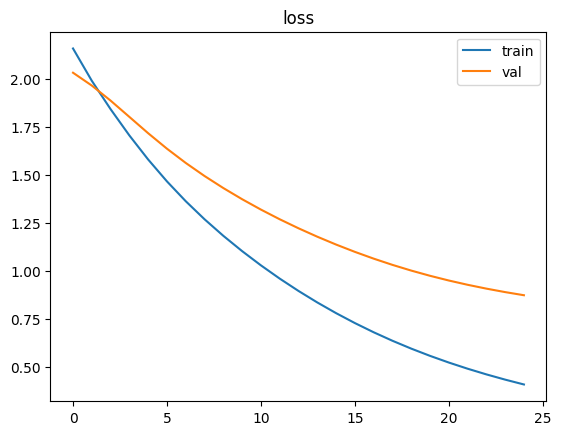

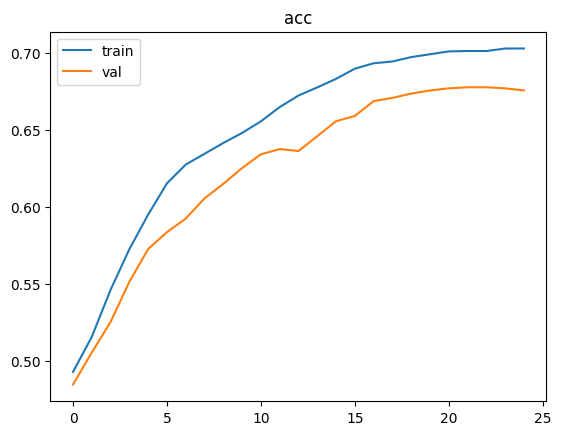

In [23]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = TinyNet(204, 8, 301, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
    ]
)
metrics = trainer.fit(train_loader, 25, val_loader)
plot_metrics(metrics)


In [24]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.39407555262247723
train_acc: 0.7065147956212362
loss: 0.9276947379112244
acc: 0.6671036779880524


Epoch 0   loss_train:  2.8189   |    acc_train:  0.5075   |    loss_val:  2.7062   |    acc_val:  0.5088
Epoch 1   loss_train:  2.6561   |    acc_train:  0.5355   |    loss_val:  2.6596   |    acc_val:  0.5279
Epoch 2   loss_train:  2.5152   |    acc_train:  0.5605   |    loss_val:  2.6016   |    acc_val:  0.5410
Epoch 3   loss_train:  2.3835   |    acc_train:  0.5832   |    loss_val:  2.5330   |    acc_val:  0.5541
Epoch 4   loss_train:  2.2595   |    acc_train:  0.6056   |    loss_val:  2.4574   |    acc_val:  0.5691
Epoch 5   loss_train:  2.1431   |    acc_train:  0.6206   |    loss_val:  2.3799   |    acc_val:  0.5904
Epoch 6   loss_train:  2.0339   |    acc_train:  0.6352   |    loss_val:  2.3049   |    acc_val:  0.6056
Epoch 7   loss_train:  1.9318   |    acc_train:  0.6433   |    loss_val:  2.2350   |    acc_val:  0.6309
Epoch 8   loss_train:  1.8364   |    acc_train:  0.6564   |    loss_val:  2.1710   |    acc_val:  0.6364
Epoch 9   loss_train:  1.7470   |    acc_train:  0.6656

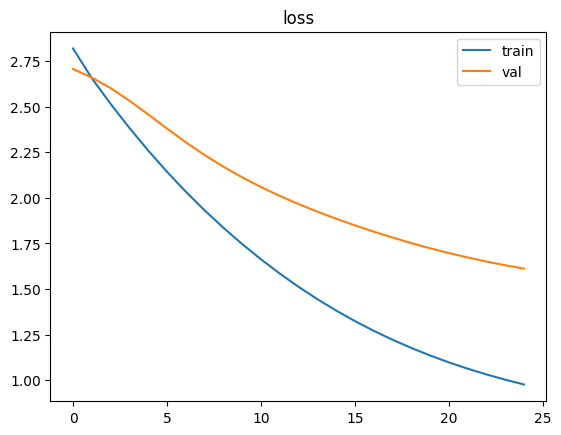

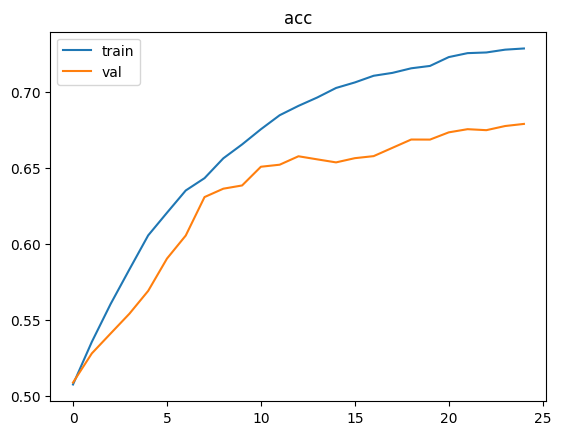

In [25]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = TinyNet(204, 8, 301, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
        # MeasureCallback(nn.BCEWithLogitsLoss(), 'bce_loss'),
        # EarlyStopping(monitor='loss_val')
        L1Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)
metrics = trainer.fit(train_loader, 25, val_loader)
plot_metrics(metrics)


In [26]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.9590540726979574
train_acc: 0.7294567624727885
loss: 1.6189676523208618
acc: 0.6604420840740204


Epoch 0   loss_train:  2.2197   |    acc_train:  0.5163   |    loss_val:  2.0732   |    acc_val:  0.5806
Epoch 1   loss_train:  2.0567   |    acc_train:  0.5401   |    loss_val:  2.0177   |    acc_val:  0.5970
Epoch 2   loss_train:  1.9158   |    acc_train:  0.5668   |    loss_val:  1.9517   |    acc_val:  0.6128
Epoch 3   loss_train:  1.7849   |    acc_train:  0.5871   |    loss_val:  1.8767   |    acc_val:  0.6307
Epoch 4   loss_train:  1.6629   |    acc_train:  0.6035   |    loss_val:  1.7959   |    acc_val:  0.6512
Epoch 5   loss_train:  1.5491   |    acc_train:  0.6215   |    loss_val:  1.7132   |    acc_val:  0.6480
Epoch 6   loss_train:  1.4432   |    acc_train:  0.6375   |    loss_val:  1.6321   |    acc_val:  0.6495
Epoch 7   loss_train:  1.3447   |    acc_train:  0.6565   |    loss_val:  1.5549   |    acc_val:  0.6531
Epoch 8   loss_train:  1.2531   |    acc_train:  0.6680   |    loss_val:  1.4827   |    acc_val:  0.6573
Epoch 9   loss_train:  1.1680   |    acc_train:  0.6744

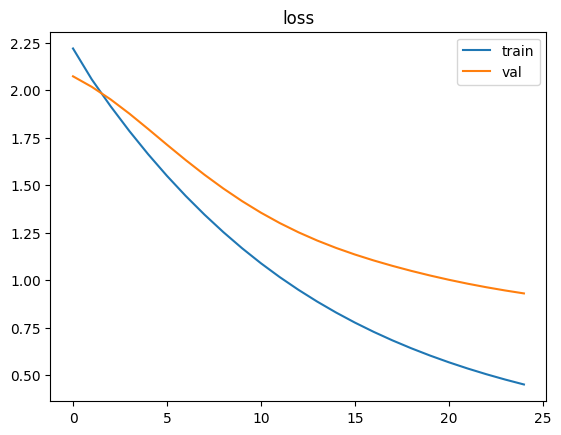

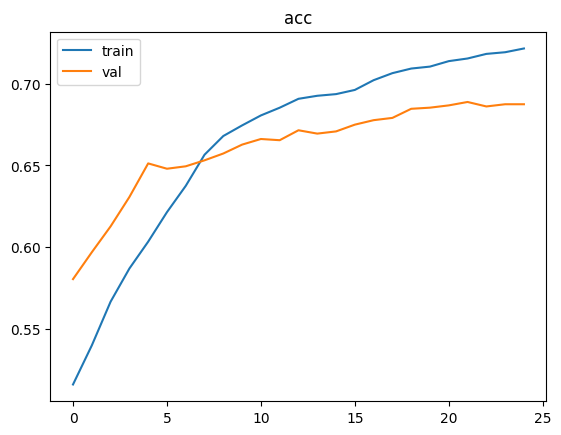

In [27]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = TinyNet(204, 8, 301, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
        # MeasureCallback(nn.BCEWithLogitsLoss(), 'bce_loss'),
        # EarlyStopping(monitor='loss_val')
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)
metrics = trainer.fit(train_loader, 25, val_loader)
plot_metrics(metrics)


In [28]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.43274680773417157
train_acc: 0.7177998423576355
loss: 0.8942700624465942
acc: 0.690487802028656


  0%|          | 0/25 [00:00<?, ?it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0   loss_train:  2.2052   |    acc_train:  0.5020   |    loss_val:  2.0971   |    acc_val:  0.6209
Epoch 1   loss_train:  2.0331   |    acc_train:  0.5288   |    loss_val:  2.0807   |    acc_val:  0.6094
Epoch 2   loss_train:  1.9001   |    acc_train:  0.5483   |    loss_val:  2.0612   |    acc_val:  0.5883
Epoch 3   loss_train:  1.7824   |    acc_train:  0.5695   |    loss_val:  2.0376   |    acc_val:  0.5860
Epoch 4   loss_train:  1.6760   |    acc_train:  0.5867   |    loss_val:  2.0102   |    acc_val:  0.5713
Epoch 5   loss_train:  1.5779   |    acc_train:  0.6003   |    loss_val:  1.9800   |    acc_val:  0.5521
Epoch 6   loss_train:  1.4872   |    acc_train:  0.6040   |    loss_val:  1.9484   |    acc_val:  0.5555
Epoch 7   loss_train:  1.4027   |    acc_train:  0.6152   |    loss_val:  1.9180   |    acc_val:  0.5444
Epoch 8   loss_train:  1.3240   |    acc_train:  0.6212   |    loss_val:  1.8912   |    acc_val:  0.5472
Epoch 9   loss_train:  1.2507   |    acc_train:  0.6297

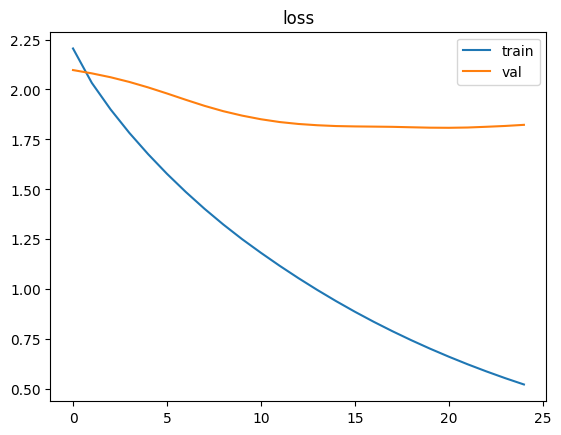

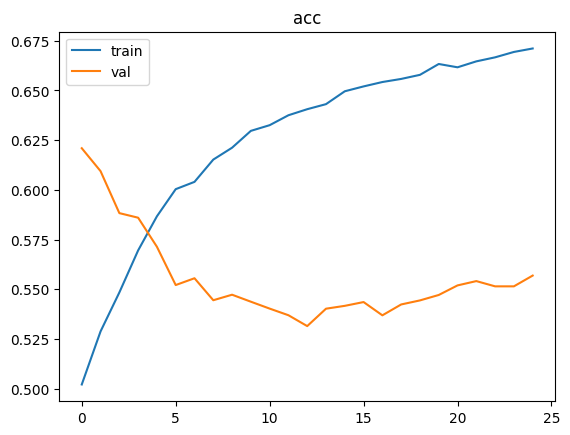

In [29]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = SimpleNet(204, 8, 301, 50, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
        # MeasureCallback(nn.BCEWithLogitsLoss(), 'bce_loss'),
        # EarlyStopping(monitor='loss_val')
    ]
)
metrics = trainer.fit(train_loader, 25, val_loader)
plot_metrics(metrics)

In [30]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.5167087018489838
train_acc: 0.6442718108495077
loss: 2.1365955471992493
acc: 0.5380792915821075


Epoch 0   loss_train:  2.7523   |    acc_train:  0.5146   |    loss_val:  2.6651   |    acc_val:  0.4818
Epoch 1   loss_train:  2.5879   |    acc_train:  0.5414   |    loss_val:  2.6641   |    acc_val:  0.4940
Epoch 2   loss_train:  2.4650   |    acc_train:  0.5599   |    loss_val:  2.6592   |    acc_val:  0.5070
Epoch 3   loss_train:  2.3571   |    acc_train:  0.5779   |    loss_val:  2.6492   |    acc_val:  0.5283
Epoch 4   loss_train:  2.2574   |    acc_train:  0.5923   |    loss_val:  2.6321   |    acc_val:  0.5282
Epoch 5   loss_train:  2.1639   |    acc_train:  0.6074   |    loss_val:  2.6084   |    acc_val:  0.5481
Epoch 6   loss_train:  2.0758   |    acc_train:  0.6179   |    loss_val:  2.5810   |    acc_val:  0.5569
Epoch 7   loss_train:  1.9933   |    acc_train:  0.6257   |    loss_val:  2.5536   |    acc_val:  0.5548
Epoch 8   loss_train:  1.9152   |    acc_train:  0.6341   |    loss_val:  2.5292   |    acc_val:  0.5630
Epoch 9   loss_train:  1.8402   |    acc_train:  0.6404

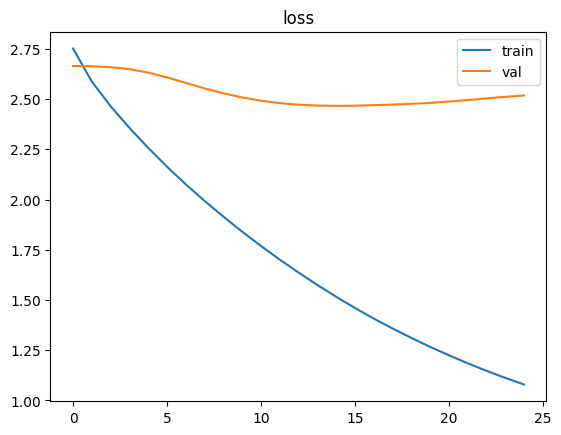

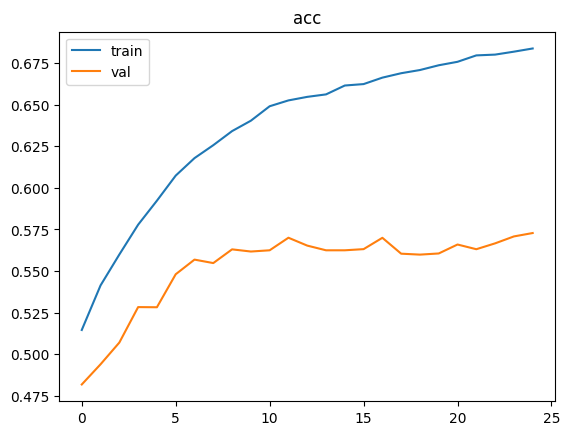

In [31]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = SimpleNet(204, 8, 301, 50, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
        # MeasureCallback(nn.BCEWithLogitsLoss(), 'bce_loss'),
        # EarlyStopping(monitor='loss_val')
        L1Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)
metrics = trainer.fit(train_loader, 25, val_loader)
plot_metrics(metrics)

In [32]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 1.0701911449432373
train_acc: 0.6857535044352213
loss: 2.409856915473938
acc: 0.574108213186264


Epoch 0   loss_train:  2.2308   |    acc_train:  0.5182   |    loss_val:  2.1031   |    acc_val:  0.6236
Epoch 1   loss_train:  2.0599   |    acc_train:  0.5510   |    loss_val:  2.1000   |    acc_val:  0.6072
Epoch 2   loss_train:  1.9301   |    acc_train:  0.5772   |    loss_val:  2.0977   |    acc_val:  0.5847
Epoch 3   loss_train:  1.8153   |    acc_train:  0.5956   |    loss_val:  2.0954   |    acc_val:  0.5814
Epoch 4   loss_train:  1.7097   |    acc_train:  0.6111   |    loss_val:  2.0914   |    acc_val:  0.5725
Epoch 5   loss_train:  1.6132   |    acc_train:  0.6272   |    loss_val:  2.0847   |    acc_val:  0.5643
Epoch 6   loss_train:  1.5234   |    acc_train:  0.6372   |    loss_val:  2.0754   |    acc_val:  0.5636
Epoch 7   loss_train:  1.4382   |    acc_train:  0.6440   |    loss_val:  2.0652   |    acc_val:  0.5718
Epoch 8   loss_train:  1.3575   |    acc_train:  0.6573   |    loss_val:  2.0553   |    acc_val:  0.5701
Epoch 9   loss_train:  1.2802   |    acc_train:  0.6610

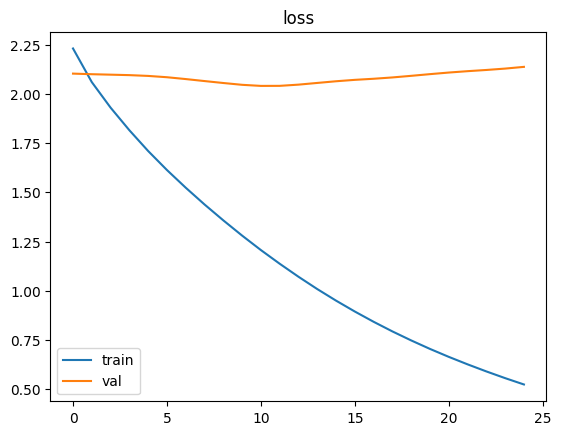

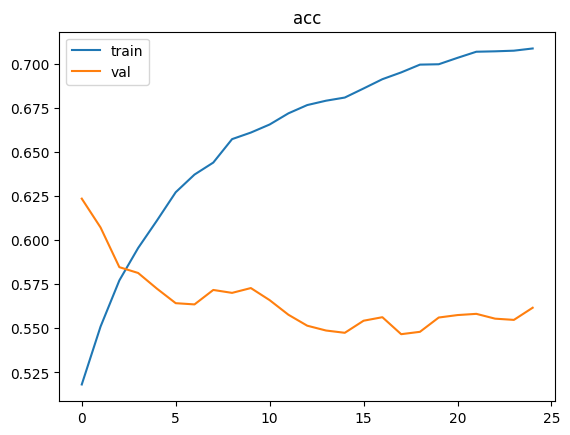

In [33]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = SimpleNet(204, 8, 301, 50, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
        # MeasureCallback(nn.BCEWithLogitsLoss(), 'bce_loss'),
        # EarlyStopping(monitor='loss_val')
        L2Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)
metrics = trainer.fit(train_loader, 25, val_loader)
plot_metrics(metrics)

In [34]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.5119697252909342
train_acc: 0.7094665169715881
loss: 2.081919312477112
acc: 0.5714862644672394


Epoch 0   loss_train:  0.7235   |    acc_train:  0.5036   |    loss_val:  0.6877   |    acc_val:  0.5417
Epoch 1   loss_train:  0.7010   |    acc_train:  0.5370   |    loss_val:  0.6876   |    acc_val:  0.5385
Epoch 2   loss_train:  0.6835   |    acc_train:  0.5677   |    loss_val:  0.6877   |    acc_val:  0.5377
Epoch 3   loss_train:  0.6683   |    acc_train:  0.5873   |    loss_val:  0.6870   |    acc_val:  0.5343
Epoch 4   loss_train:  0.6545   |    acc_train:  0.6093   |    loss_val:  0.6846   |    acc_val:  0.5397
Epoch 5   loss_train:  0.6415   |    acc_train:  0.6254   |    loss_val:  0.6799   |    acc_val:  0.5541
Epoch 6   loss_train:  0.6294   |    acc_train:  0.6417   |    loss_val:  0.6734   |    acc_val:  0.5713
Epoch 7   loss_train:  0.6182   |    acc_train:  0.6580   |    loss_val:  0.6659   |    acc_val:  0.5849
Epoch 8   loss_train:  0.6076   |    acc_train:  0.6747   |    loss_val:  0.6582   |    acc_val:  0.5987
Epoch 9   loss_train:  0.5977   |    acc_train:  0.6836

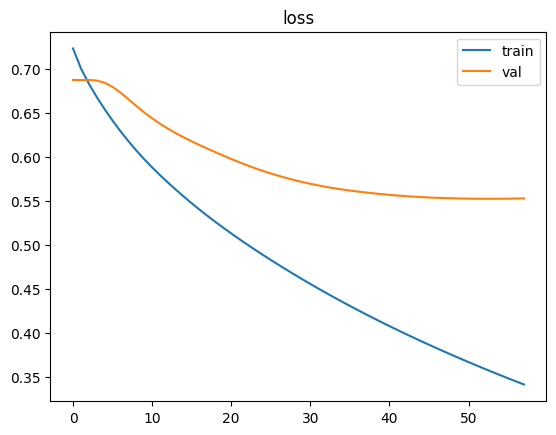

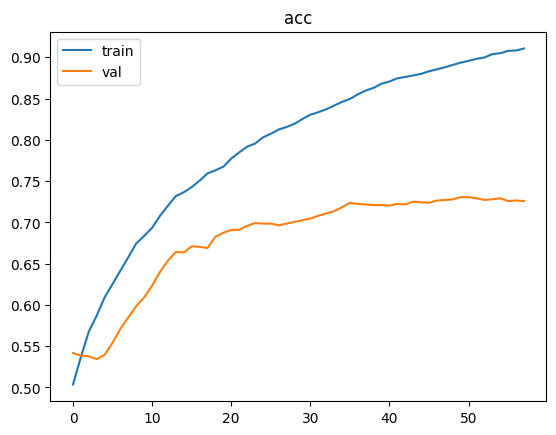

In [16]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = LFCNN(204, 8, 301, 50, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
# criterion = torch.nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)
early_stopper = EarlyStopping(monitor='loss_val')

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
        # MeasureCallback(nn.BCEWithLogitsLoss(), 'bce_loss'),
        early_stopper
    ]
)
metrics = trainer.fit(train_loader, 150, val_loader)
plot_metrics(metrics)

In [17]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.35819151004155475
train_acc: 0.9033722678820292
loss: 0.5514173209667206
acc: 0.7276066839694977


In [18]:
early_stopper.restore()

In [19]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.35819151004155475
train_acc: 0.9033722678820292
loss: 0.5498221516609192
acc: 0.7303048968315125


Epoch 0   loss_train:  1.2926   |    acc_train:  0.5313   |    loss_val:  1.2610   |    acc_val:  0.5468
Epoch 1   loss_train:  1.2673   |    acc_train:  0.5564   |    loss_val:  1.2540   |    acc_val:  0.5591
Epoch 2   loss_train:  1.2483   |    acc_train:  0.5781   |    loss_val:  1.2465   |    acc_val:  0.5770
Epoch 3   loss_train:  1.2325   |    acc_train:  0.6073   |    loss_val:  1.2382   |    acc_val:  0.6011
Epoch 4   loss_train:  1.2189   |    acc_train:  0.6334   |    loss_val:  1.2294   |    acc_val:  0.6142
Epoch 5   loss_train:  1.2068   |    acc_train:  0.6508   |    loss_val:  1.2211   |    acc_val:  0.6225
Epoch 6   loss_train:  1.1960   |    acc_train:  0.6675   |    loss_val:  1.2142   |    acc_val:  0.6281
Epoch 7   loss_train:  1.1865   |    acc_train:  0.6778   |    loss_val:  1.2080   |    acc_val:  0.6358
Epoch 8   loss_train:  1.1775   |    acc_train:  0.6910   |    loss_val:  1.2026   |    acc_val:  0.6542
Epoch 9   loss_train:  1.1689   |    acc_train:  0.7015

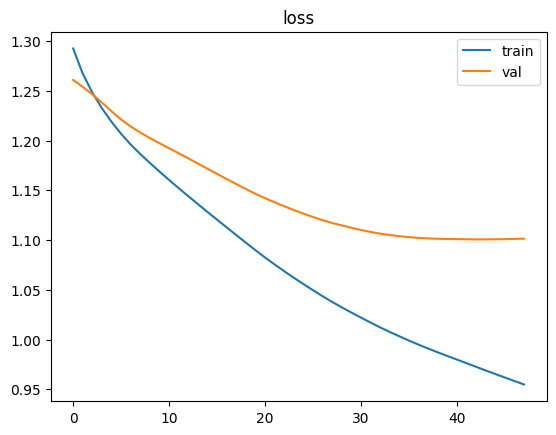

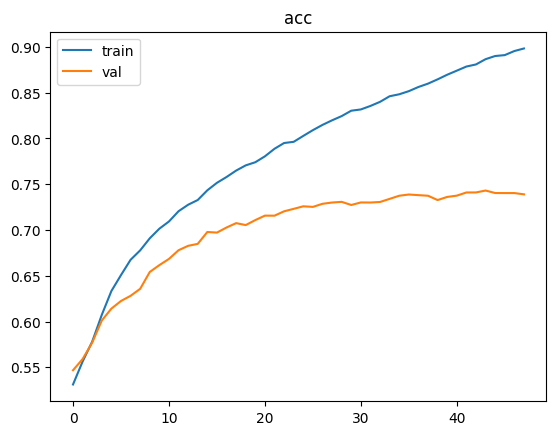

In [9]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = LFCNN(204, 8, 301, 50, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
# criterion = torch.nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
        # MeasureCallback(nn.BCEWithLogitsLoss(), 'bce_loss'),
        EarlyStopping(monitor='loss_val'),
        L1Reg(
            [
                'unmixing_layer.weight'
            ], lambdas=.01
        )
    ]
)
metrics = trainer.fit(train_loader, 150, val_loader)
plot_metrics(metrics)

In [10]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.969953199227651
train_acc: 0.8862091104189554
loss: 1.1177380084991455
acc: 0.7297561168670654


In [44]:
model.state_dict().keys()

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'unmixing_layer_batchnorm.running_mean', 'unmixing_layer_batchnorm.running_var', 'unmixing_layer_batchnorm.num_batches_tracked', 'temp_conv.weight', 'features_batchnorm.running_mean', 'features_batchnorm.running_var', 'features_batchnorm.num_batches_tracked', 'fc_layer.weight', 'fc_layer.bias'])

Epoch 0   loss_train:  0.7606   |    acc_train:  0.5055   |    loss_val:  0.7227   |    acc_val:  0.5239
Epoch 1   loss_train:  0.7376   |    acc_train:  0.5291   |    loss_val:  0.7207   |    acc_val:  0.5294
Epoch 2   loss_train:  0.7190   |    acc_train:  0.5579   |    loss_val:  0.7184   |    acc_val:  0.5430
Epoch 3   loss_train:  0.7026   |    acc_train:  0.5861   |    loss_val:  0.7157   |    acc_val:  0.5535
Epoch 4   loss_train:  0.6878   |    acc_train:  0.6092   |    loss_val:  0.7120   |    acc_val:  0.5582
Epoch 5   loss_train:  0.6743   |    acc_train:  0.6341   |    loss_val:  0.7072   |    acc_val:  0.5726
Epoch 6   loss_train:  0.6619   |    acc_train:  0.6537   |    loss_val:  0.7016   |    acc_val:  0.5767
Epoch 7   loss_train:  0.6505   |    acc_train:  0.6638   |    loss_val:  0.6958   |    acc_val:  0.5939
Epoch 8   loss_train:  0.6402   |    acc_train:  0.6855   |    loss_val:  0.6902   |    acc_val:  0.5993
Epoch 9   loss_train:  0.6307   |    acc_train:  0.6942

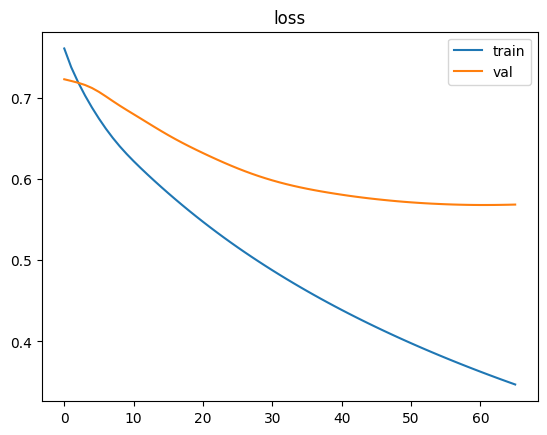

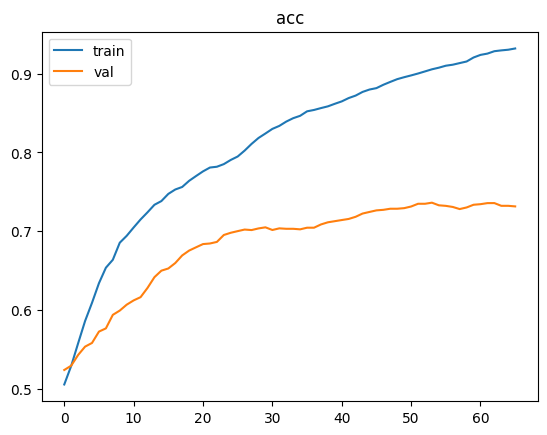

In [6]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
batch_size = 200
val_size = 60
train_loader, val_loader = make_train_and_val_loaders(train, batch_size, val_size)
test_loader = DataLoader(test, batch_size, shuffle=True)
model = LFCNN(204, 8, 301, 50, 10, 8)
optimizer = torch.optim.Adam(model.parameters())
# criterion = torch.nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
metric = ('acc', torchmetrics.functional.classification.binary_accuracy)

trainer = Trainer(
    model, optimizer, criterion, 'cpu', [metric],
    callbacks=[
        PrintingCallback(),
        # MeasureCallback(nn.BCEWithLogitsLoss(), 'bce_loss'),
        EarlyStopping(monitor='loss_val'),
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        )
    ]
)
metrics = trainer.fit(train_loader, 150, val_loader)
plot_metrics(metrics)

In [7]:
train_result = trainer.evaluate(train_loader)
result = trainer.evaluate(test_loader)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.3628229995568593
train_acc: 0.923960268497467
loss: 0.5508524179458618
acc: 0.7439634203910828


In [96]:
model.temp_conv.weight[:, 0, :].shape

torch.Size([8, 50])

In [99]:
model.unmixing_layer.weight[:, :, 0]

torch.Size([8, 204])

In [23]:
from mne.datasets import multimodal

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
# for c in cond:
#     c['tmax'] = 1.2
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')

Number of events,940
Events,Auditory left: 117Auditory right: 104Somato left: 118Somato right: 107Visual Lower left: 115Visual Lower right: 129Visual Upper left: 133Visual Upper right: 117
Time range,-0.100 – 0.499 sec
Baseline,-0.100 – 0.000 sec


In [41]:
epochs.get_data().shape

(940, 204, 361)

In [37]:
epochs.apply_baseline((None, 0))
epochs.crop(0, None)

Number of events,940
Events,Auditory left: 117Auditory right: 104Somato left: 118Somato right: 107Visual Lower left: 115Visual Lower right: 129Visual Upper left: 133Visual Upper right: 117
Time range,0.000 – 0.499 sec
Baseline,-0.100 – 0.000 sec


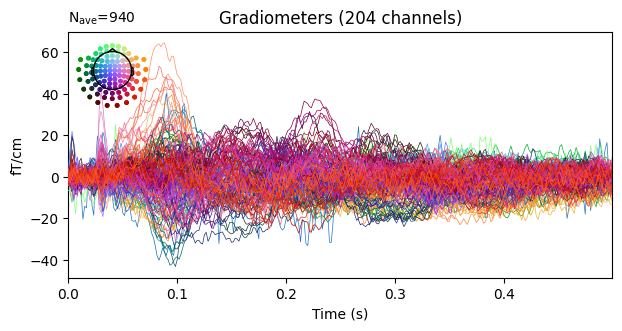

In [70]:
fig = epochs.average().plot()

In [38]:


dataset = EpochsDataset(epochs, savepath='../trash', transform = transform)

In [39]:
dataset.save('../data/dataset.pt')

In [29]:
dataset = read_epochs_dataset('../data/dataset.pt')

In [33]:
x, y = dataset[0]

In [9]:
x.shape

torch.Size([204, 361])

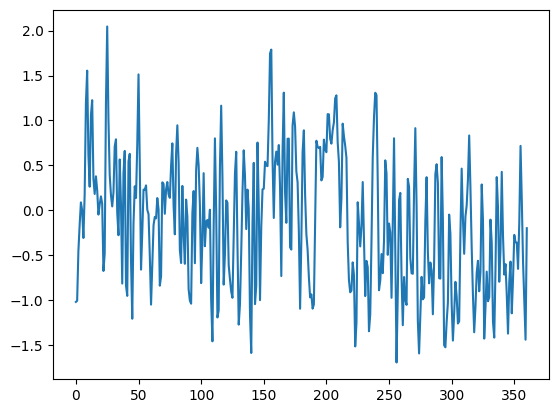

In [34]:
plt.plot(x[0])

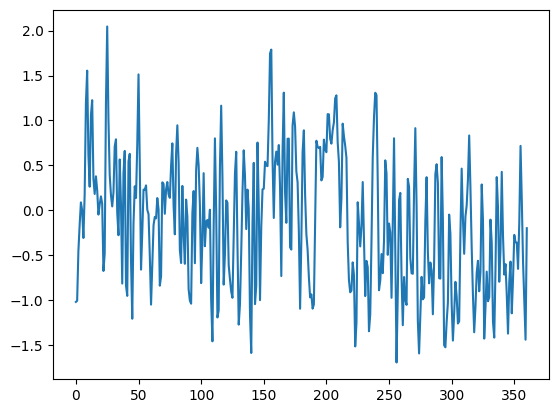

In [21]:
plt.plot(x_s[0])